In [1]:
import numpy as np
import cv2
from keras.preprocessing import image
import time

import sys
import os
import glob
import re
import scipy
import tensorflow as tf
import align.detect_face
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten



# Keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.
/home/topica/anaconda3/envs/workspace/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/topica/anaconda3/envs/workspace/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from keras.models import model_from_json
# model = model_from_json(open("/home/thaovu/tensorflow-101/model/facial_expression_model_structure.json", "r").read())
# model.load_weights('/home/thaovu/tensorflow-101/model/facial_expression_model_weights.h5') #load weights
# model = model_from_json(open("/home/topica/workspace/Facial-Expression-Recognition/model_4layer_2_2_pool.json", "r").read())
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(224, 224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='sigmoid'))
model.summary()
# model.load_weights('/home/topica/workspace/Facial-Expression-Recognition/model_4layer_2_2_pool.h5') #load weights
model.load_weights('/home/topica/workspace/final_model_fold6_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 128)     512       
__________

In [ ]:
from __future__ import print_function
from __future__ import absolute_import
from keras.models import Sequential
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Permute, merge, Flatten, concatenate
from keras.callbacks import TensorBoard, ModelCheckpoint
# import keras.layers
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
# from imagenet_utils import decode_predictions
#from keras.applications.vgg16 import preprocess_input, decode_prediction
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
#from keras.layers import concatenate as concat

# from imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
# from __future__ import print_function
# from __future__ import absolute_import
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from imutils import paths

import cv2
import keras.layers
import numpy as np
import keras
import tensorflow as tf


import os, sys
# from imutils import paths
import random
import argparse

In [ ]:
def DeXpression(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                padding=None,
                classes=6):
    # Check weights
    if weights not in {'dexpression', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `dexpression` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 6:
        raise ValueError('If using `weights` as dexpression with `include_top`'
                         ' as true, `classes` should be 6')
    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=139,
        data_format=K.image_data_format(),
        require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    # START MODEL
    conv_1 = Convolution2D(64, (7, 7), strides=(2, 2), padding=padding, activation='relu', name='conv_1')(img_input)
    maxpool_1 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    x = BatchNormalization()(maxpool_1)
    
    # FEAT-EX1
    conv_2a = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_2a')(x)
    conv_2b = Convolution2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_2b')(conv_2a)
    maxpool_2a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2a')(x)
    conv_2c = Convolution2D(64, (1, 1), strides=(1,1), name='conv_2c')(maxpool_2a)
    concat_1 = concatenate([conv_2b,conv_2c],axis=3,name='concat_2')
    maxpool_2b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2b')(concat_1)
    
    # FEAT-EX2
    conv_3a = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_3a')(maxpool_2b)
    conv_3b = Convolution2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_3b')(conv_3a)
    maxpool_3a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3a')(maxpool_2b)
    conv_3c = Convolution2D(64, (1, 1), strides=(1,1), name='conv_3c')(maxpool_2a)
    concat_3 = concatenate([conv_3b,conv_3c],axis=3,name='concat_3')
    maxpool_3b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3b')(concat_3)
    
    # FINAL LAYERS
    net = Flatten()(maxpool_3b)
    net = Dense(classes, activation='softmax', name='predictions')(net)
    
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, net, name='deXpression')
    return model

model= DeXpression(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                padding='same',
                classes=6)
model.summary()
model.load_weights('/home/topica/workspace/weights-improvement-78-0.94.h5')

In [4]:
test_img = "/media/topica/DATA/DATA_DATA/train/anger/aug_1324.jpg"

In [5]:
img = cv2.imread(test_img)
#         x = image.img_to_array(img)
img = cv2.resize(img,(224,224))
img = np.expand_dims(img, axis = 0)

In [6]:
img.shape

(1, 224, 224, 3)

In [7]:
a = model.predict(img)

In [8]:
a

array([[0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
np.argmax(a)

0

In [10]:
test_dir = "/home/topica/workspace/test"

In [ ]:
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

In [11]:
emotions = ['anger', 'fear', 'happy', 'sadness', 'surprise', 'neutral']

In [ ]:
test_data =[]
test_label = []
for i in  range(len(emotions)):
    emotion_dir = os.path.join(test_dir,emotions[i])
    list_img = os.listdir(emotion_dir)
    print(list_img)
    for j in range(len(list_img)):
        print(j)
        img_dir = os.path.join(emotion_dir, list_img[j])
        print(img_dir)
        img = image.load_img(img_dir, grayscale=True, target_size=(48, 48,1))
        x = image.img_to_array(img)
        print(x)
        test_data.append(x)
        test_label.append(i)

In [12]:
import cv2

test_data =[]
test_label = []
for i in  range(len(emotions)):
    emotion_dir = os.path.join(test_dir,emotions[i])
    list_img = os.listdir(emotion_dir)
    for j in range(len(list_img)):
        img_dir = os.path.join(emotion_dir, list_img[j])
        img = cv2.imread(img_dir)
#         x = image.img_to_array(img)
        img = cv2.resize(img,(224,224))
        test_data.append(img)
        test_label.append(i)

In [13]:
test_data = np.asarray(test_data)
test_label = np.asarray(test_label)

In [14]:
from sklearn.preprocessing import label_binarize

In [15]:
test_label = label_binarize(test_label, classes=[0, 1, 2, 3, 4, 5])

In [16]:
test_data.shape


(579, 224, 224, 3)

In [17]:
test_label.shape

(579, 6)

In [18]:
test_label 

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
(579, 6)


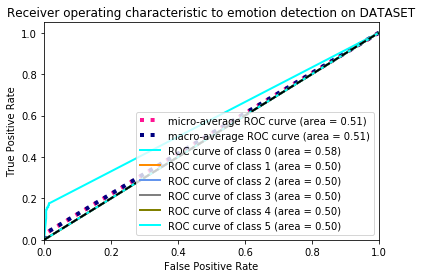

In [20]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
n_classes = 6
roc_auc = dict()
y_score = model.predict(test_data)
print(y_score)
print(y_score.shape)
# y_score = (y_score == y_score.max(axis=1)[:,None]).astype(int)
# print(y_score)
# print(y_score.shape)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','gray','olive', 'cyan', ])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to emotion detection on DATASET')
plt.legend(loc="lower right")
plt.show()


In [ ]:
faces